<a href="https://colab.research.google.com/github/achanhon/coursdeeplearningcolab/blob/master/TP_ADVERSAIRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#deep learning sous attaque adversaire

L'objet de ce TP est de démontrer
- la faciliter de produire des attaques adversaires "white box" sur des réseaux naifs quelles soient invisibles ou par patch
- mais que cela est beaucoup plus dur sur un réseau robustifier (cas invisible)
- ou encore qu'il est beaucoup plus difficile de produire des attaques "transferable"

## generalité

Commençons par télécharger 10 images d'imagenet.

In [14]:
!rm *
!wget https://httpmail.onera.fr/21/500df56b6a7a034ecc2f3e0345f1ce9cYqsE3G/data.zip
!unzip data.zip
!ls

--2024-09-23 18:41:49--  https://httpmail.onera.fr/21/500df56b6a7a034ecc2f3e0345f1ce9cYqsE3G/data.zip
Resolving httpmail.onera.fr (httpmail.onera.fr)... 144.204.16.9
Connecting to httpmail.onera.fr (httpmail.onera.fr)|144.204.16.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 723589 (707K) [application/force-download]
Saving to: ‘data.zip’

data.zip            100%[===================>] 706.63K  1.27MB/s    in 0.5s    

2024-09-23 18:41:50 (1.27 MB/s) - ‘data.zip’ saved [723589/723589]

Archive:  data.zip
 extracting: 0.png                   
  inflating: 1.png                   
 extracting: 2.png                   
 extracting: 3.png                   
  inflating: 4.png                   
 extracting: 5.png                   
 extracting: 6.png                   
 extracting: 7.png                   
 extracting: 8.png                   
 extracting: 9.png                   
0.png  1.png  2.png  3.png  4.png  5.png  6.png  7.png	8.png  9.png  data.zip


Affichons les : les 5 premières sont des "avions" et les 5 suivantes des "requins"

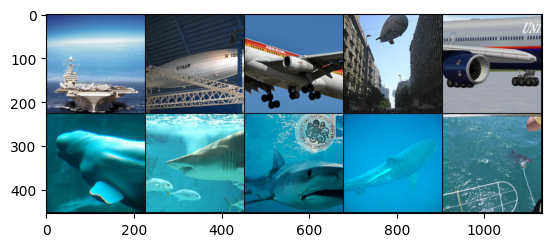

In [25]:
import torch
import torchvision
import matplotlib.pyplot as plt

x = [torchvision.io.read_image(str(i)+".png") for i in range(10)]
x = torch.stack(x,dim=0).float()/255

visu = torchvision.utils.make_grid(x, nrow=5)
plt.imshow(visu.permute(1, 2, 0).numpy())
plt.show()

In [30]:
SHARK, PLANE = [2, 3, 4], [403, 404, 405]
normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
resnet = torchvision.models.resnet101(
    weights=torchvision.models.ResNet101_Weights.IMAGENET1K_V1
).eval()

with torch.no_grad():
    z = resnet(normalize(x))
    _,z = z.max(1)
    print(z)

tensor([403, 405, 404, 405, 404,   4,   3,   3,   3,   2])


On voit que le réseau classe correctement ces images.

## Attaque

On va maintenant rajouter à ces images un petit bruit "invisible" pour l'oeil mais perturbant pour le réseau.

In [ ]:
y = torch.Tensor([403, 405, 404, 405, 404,   4,   3,   3,   3,   2]).long()
cefunction = torch.nn.CrossEntropyLoss()
attaque = torch.nn.Parameter(torch.zeros(x.shape, requires_grad=True))
optimizer = torch.optim.SGD([attaque],lr=0.0001)

for i in range(25):
  z = resnet(normalize(x+attaque))
  ce = cefunction(z,y)
  print(i,ce)
  ce = -ce # on veut MAXIMISER la cross entropy puisqu'on attaque
  optimizer.zero_grad()
  ce.backward()
  optimizer.step()
  with torch.no_grad():
      attaque = torch.clamp(attaque, -5./255,+5/255)
      # l'attaque doit être invisible

      attaque = attaque*((x+attaque)>=0).float()
      attaque = attaque*((x+attaque)<1).float() + ((x+attaque)>=1).float()
      # attaque+x doit être entre 0 et 1

      attaque = torch.nn.Parameter(attaque.clone())
      optimizer = torch.optim.SGD([attaque],lr=0.0001)


with torch.no_grad():
    z = resnet(normalize(x+attaque))
    _,z = z.max(1)
    print(z)

Les images "x+attaque" sont désormais mal classées !
Pourtant, l'attaque ne se voit pas :

tensor([403, 405, 404, 442, 404,   4,   3,   3,   3,   2])


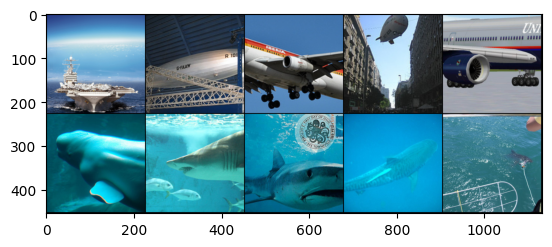

In [41]:
visu = torchvision.utils.make_grid(x+attaque, nrow=5)
plt.imshow(visu.permute(1, 2, 0).numpy())
plt.show()